# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
# download the required data files

!wget -cq https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!wget -cq https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip

In [2]:
# unzip the data files

!rm -r dogImages || true
!unzip -qq dogImages.zip

!rm -r lfw || true
!unzip -qq lfw.zip

!rm -r __MACOSX || true

rm: cannot remove 'dogImages': No such file or directory
rm: cannot remove 'lfw': No such file or directory


In [3]:
# all imports

import numpy as np
from glob import glob
import cv2                
import matplotlib.pyplot as plt 
from tqdm import tqdm
from PIL import Image
from PIL import ImageFile
import os
from collections import OrderedDict
import time
import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.models as models
from torchvision import datasets

%matplotlib inline       

In [4]:
# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


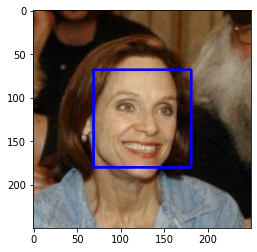

In [6]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [7]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
Using haarcascades face detector:

Detected human faces in the first 100 human images: 96%

Detected faces in the first 100 dogs images: 16%

In [8]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

count = []
temp = 0
for file in tqdm(human_files_short):
  if face_detector(file):
    temp += 1
count.append(temp)    

temp = 0
for file in tqdm(dog_files_short):
  if face_detector(file):
    temp += 1
count.append(temp)   
    
print('\nPercentage of human face detected in the first 100 images:\nhuman_files:{}\tdog_files:{}'.format(count[0], count[1]))

100%|██████████| 100/100 [00:28<00:00,  3.46it/s]


Percentage of human face detected in the first 100 images:
human_files:99	dog_files:16


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [ ]:
### (Optional) 
### TODO: Test performance of another face detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [9]:
# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [10]:
def process_image(image):
    ''' 
    Scales, crops, and normalizes a PIL image for a PyTorch       
    model, returns an Numpy array
    '''
    # Open the image
    from PIL import Image
    img = Image.open(image)
    # Resize
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256))
    else:
        img.thumbnail((256, 10000))
    # Crop 
    left_margin = (img.width-224)/2
    bottom_margin = (img.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop((left_margin, bottom_margin, right_margin,   
                      top_margin))
    # Normalize
    img = np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406]) 
    std = np.array([0.229, 0.224, 0.225]) 
    img = (img - mean)/std
    
    # Move color channels to first dimension as expected by PyTorch
    img = img.transpose((2, 0, 1))    
    
    return img

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [11]:
# Set PIL to be tolerant of image files that are truncated.
ImageFile.LOAD_TRUNCATED_IMAGES = True

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''    
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    # Process image
    img = process_image(img_path) 
    img = torch.from_numpy(img).type(torch.FloatTensor) 
    img.unsqueeze_(0)
    img = img.cuda()

    # Predict top label
    probs = torch.exp(VGG16.forward(img)) 
    top_prob, top_lab = probs.topk(1)     
    
    return top_lab # predicted class index

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


In [15]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
### Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

count = []
temp = 0
for file in tqdm(human_files_short):
  if dog_detector(file):
    temp += 1
count.append(temp)    

temp = 0
for file in tqdm(dog_files_short):
  if dog_detector(file):
    temp += 1
count.append(temp)   
    
print('\nPercentage of dogs detected in the first 100 images:\nhuman_files:{}\tdog_files:{}'.format(count[0], count[1]))

100%|██████████| 100/100 [00:02<00:00, 48.41it/s]


Percentage of dogs detected in the first 100 images:
human_files:2	dog_files:89


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [12]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.
int(VGG16_predict('dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'))

252

In [14]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    pred = int(VGG16_predict(img_path))
    if 150 < pred <269:
      return True
    else:    
      return False 

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [17]:
### Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
# Transforms for the training and validation sets

data_transforms = {
    'train': transforms.Compose([        
        transforms.ColorJitter(brightness=.2, contrast=.2, saturation=.2),
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])
}

In [18]:

dirs = {'train': 'dogImages/train', 
        'valid': 'dogImages/valid',
        'test': 'dogImages/test'}

image_datasets = {x: datasets.ImageFolder(dirs[x],   transform=data_transforms[x]) for x in ['train', 'valid', 'test']}
loaders_scratch = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64, shuffle=True) for x in ['train', 'valid', 'test']}
dataset_sizes = {x: len(image_datasets[x]) 
                              for x in ['train', 'valid', 'test']}

class_names = image_datasets['train'].classes

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:

I loaded in the training, test and validation data, then created DataLoaders for each of these sets of data.

I resized all image to 224, center cropped and added some simple data augmentation by randomly flipping and rotating the given image data.

I approached the problem iteratively, starting with the examples from the previous labs, especially Cifar and MMNIST examples.

We are working with (224, 224, 3) images in this project so the inputs are significantly bigger than the labs (28, 28, 1) for Mnist and (32x32x3) for CIFAR.

Most of the pretrained models require the input to be 224x224 images. Also, we'll need to match the normalization used when the models were trained. Each color channel was normalized separately, the means are [0.485, 0.456, 0.406] and the standard deviations are [0.229, 0.224, 0.225].

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [19]:
# define the CNN architecture
class Net(nn.Module):
    ### choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        # convolutional layer (sees 224x224x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 112x112x112 tensor)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1)
        # convolutional layer (sees 56x56x56 tensor)
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 28x28x28 tensor)
        self.conv4 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (512 * 14 * 14 -> 4096)
        self.fc1 = nn.Linear(64*14*14, 4096)
        # linear layer (4096 -> 4096)
        self.fc2 = nn.Linear(4096, 4096)
        # linear layer (4096 -> number of classes)
        self.fc3 = nn.Linear(4096, len(class_names))
        # dropout layer (p=0.5)
        self.dropout = nn.Dropout(0.5)        
    
    def forward(self, x):
        ## Define forward behavior
        # add sequence of convolutional and max pooling layers        
        x = self.pool(F.relu(self.conv1(x)))       
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        # flatten image input, size is depth of image in previous maxpool*depth of convolution
        x = x.view(-1, 64*14*14)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc3(x)
        return x

# instantiate the CNN
model_scratch = Net()
print(model_scratch)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=133, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

First layer has input shape of (224, 224, 3) and last layer should output 133 classes.

I started adding Convolutional layers (stack of filtered images) and Maxpooling layers(reduce the x-y size of an input, keeping only the most active pixels from the previous layer) as well as the usual Linear + Dropout layers to avoid overfitting and produce a 133-dim output.

MaxPooling2D seems to be a common choice to downsample in these type of classification problems and that is why I chose it.

The more convolutional layers we include, the more complex patterns in color and shape a model can detect.

The first layer in my CNN is a convolutional layer that takes (224, 224, 3) inpute shap.

I'd like my new layer to have 16 filters, each with a height and width of 3. When performing the convolution, I'd like the filter to jump 1 pixel at a time.

_nn.Conv2d(in_channels, out_channels, kernelsize, stride=1, padding=0)

I want this layer to have the same width and height as the input layer, so I will pad accordingly;
Then, to construct this convolutional layer, I would use the following line of code: self.conv2 = nn.Conv2d(3, 32, 3, padding=1)

I am adding a pool layer that takes in a kernel_size and a stride after every convolution layer. This will down-sample the input's x-y dimensions, by a factor of 2:

self.pool = nn.MaxPool2d(2,2)

I am adding a fully connected Linear Layer to produce a 133-dim output. As well as a Dropout layer to avoid overfitting.

Forward pass would give:

torch.Size([16, 3, 224, 224])

torch.Size([16, 16, 112, 112])

torch.Size([16, 32, 56, 56])

torch.Size([16, 64, 28, 28])

torch.Size([16, 50176])

torch.Size([16, 500])

torch.Size([16, 133])

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [20]:
### select loss function
criterion_scratch = nn.CrossEntropyLoss()

### select optimizer
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 4 epochs
scheduler_scratch = lr_scheduler.StepLR(optimizer_scratch, step_size = 8, gamma=0.1)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [21]:
all_losses = {'epoch': [],
              'train': [],
              'valid': [],
              'test': []
             }

all_accuracies = {'epoch': [],
                  'train': [],
                  'valid': [],
                  'test': []
             }


def print_current_time():
  # Display time in IST(UTC+5:30)
  hours, mins, secs = str(datetime.datetime.now().time())[:-8].split(':')
  hours, mins, secs = int(hours), int(mins), int(secs)

  if (mins+30)<60:
    hours = hours+5 
    mins=mins+30 
  else:
    hours = hours+6 
    mins = (mins+30) - 60
    
  print('Current time - {}:{}:{}'.format(hours, mins, secs)) 

# the following import is required for training to be robust to truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    print_current_time()       
    
    for epoch in range(1, n_epochs+1):
        all_losses['epoch'].append(epoch)
        all_accuracies['epoch'].append(epoch)
        start_time = time.time()
        print('-'*11)
        print('Epoch: {}'.format(epoch))
       
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        train_running_corrects = 0
        valid_running_corrects = 0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders_scratch['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
                                
            # clear the gradients of all optimized variables
            optimizer_scratch.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model_scratch(data)
            _, preds = torch.max(outputs, 1)
            # calculate the batch loss
            loss = criterion_scratch(outputs, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer_scratch.step()
            # update training loss
            train_loss += loss.item()*data.size(0)
            train_running_corrects += torch.sum(preds == target.data)   
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders_scratch['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model_scratch(data)
            _, preds = torch.max(outputs, 1)
            # calculate the batch loss
            loss = criterion_scratch(outputs, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
            valid_running_corrects += torch.sum(preds == target.data)
            
        # calculate average losses and accuracies
        train_loss = train_loss/len(loaders_scratch['train'].dataset)
        all_losses['train'].append(train_loss)
        valid_loss = valid_loss/len(loaders_scratch['valid'].dataset)
        all_losses['valid'].append(valid_loss)

        train_acc = train_running_corrects.double()/len(loaders_scratch['train'].dataset)
        all_accuracies['train'].append(train_acc)
        valid_acc = valid_running_corrects.double()/len(loaders_scratch['valid'].dataset)
        all_accuracies['valid'].append(valid_acc)
        time_epoch = time.time() - start_time

            
        # print training/validation statistics 
        print('Training Loss: {:.6f} \tValidation Loss: {:.6f}\tTime: {:.0f}m {:.0f}s'.format(             
            train_loss,
            valid_loss,
            time_epoch // 60, time_epoch % 60
            ))
        
        ## save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
          print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
          valid_loss_min,
          valid_loss))
          torch.save(model_scratch.state_dict(), 'model_scratch.pt')
          valid_loss_min = valid_loss  
          
        # every 5 epochs print current time
        if epoch%5 == 0:
          print('*'*11)
          print_current_time()
          print('*'*11)          
        
    print()
            
    # return trained model
    return model


# train the model
model_scratch = train(30, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Current time - 19:14:2
-----------
Epoch: 1
Training Loss: 4.880693 	Validation Loss: 4.859005	Time: 4m 0s
Validation loss decreased (inf --> 4.859005).  Saving model ...
-----------
Epoch: 2
Training Loss: 4.842360 	Validation Loss: 4.767174	Time: 3m 57s
Validation loss decreased (4.859005 --> 4.767174).  Saving model ...
-----------
Epoch: 3
Training Loss: 4.726326 	Validation Loss: 4.598427	Time: 3m 49s
Validation loss decreased (4.767174 --> 4.598427).  Saving model ...
-----------
Epoch: 4
Training Loss: 4.611787 	Validation Loss: 4.477365	Time: 3m 47s
Validation loss decreased (4.598427 --> 4.477365).  Saving model ...
-----------
Epoch: 5
Training Loss: 4.565732 	Validation Loss: 4.426535	Time: 3m 48s
Validation loss decreased (4.477365 --> 4.426535).  Saving model ...
***********
Current time - 19:33:5
***********
-----------
Epoch: 6
Training Loss: 4.537204 	Validation Loss: 4.407891	Time: 3m 46s
Validation loss decreased (4.426535 --> 4.407891).  Saving model ...
-----------


<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [22]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 4.001913


Test Accuracy:  9% (78/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [23]:
## TODO: Specify data loaders
### Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
# Transforms for the training and validation sets

data_transforms = {
    'train': transforms.Compose([        
        transforms.ColorJitter(brightness=.2, contrast=.2, saturation=.2),
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])
}

In [24]:
dirs = {'train': 'dogImages/train', 
        'valid': 'dogImages/valid',
        'test': 'dogImages/test'}

image_datasets = {x: datasets.ImageFolder(dirs[x],   transform=data_transforms[x]) for x in ['train', 'valid', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64, shuffle=True) for x in ['train', 'valid', 'test']}
dataset_sizes = {x: len(image_datasets[x]) 
                              for x in ['train', 'valid', 'test']}

class_names = image_datasets['train'].classes

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [25]:
## Specify model architecture 
# Load the pretrained model from pytorch
model_transfer = models.densenet161(pretrained=True)

if use_cuda:
    model_transfer = model_transfer.cuda()
    
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(model_transfer.classifier.in_features, model_transfer.classifier.out_features)),
                          ('relu', nn.ReLU()),                          
                          ('fc2', nn.Linear(model_transfer.classifier.out_features, len(class_names))),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))  

# Freeze training for all "features" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False
    
model_transfer.classifier = classifier

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

It is very efficient to use pre-trained networks to solve challenging problems in computer vision.

Once trained, these models work very well as feature detectors for images they weren't trained on. Here we'll use transfer learning to train a network that can classify our dog photos.

For this task speciffically, I'll use resnet50 trained on ImageNet available from torchvision.

The classifier part of the model is a single fully-connected layer:

(fc): Linear(in_features=2048, out_features=1000, bias=True)

This layer was trained on the ImageNet dataset, so it won't work for the dog classification specific problem.

That means we need to replace the classifier (133 classes), but the features will work perfectly on their own.

Choice of criterion: nn.CrossEntropyLoss() This criterion combines :func:nn.LogSoftmax and :func:nn.NLLLoss in one single class. It is useful when training a classification problem with C classes.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [26]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.classifier.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 4 epochs
scheduler_transfer = lr_scheduler.StepLR(optimizer_transfer, step_size = 3, gamma=0.1)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [33]:
all_losses = {'epoch': [],
              'train': [],
              'valid': [],
              'test': []
             }

all_accuracies = {'epoch': [],
                  'train': [],
                  'valid': [],
                  'test': []
             }

def print_current_time():
  
  hours, mins, secs = str(datetime.datetime.now().time())[:-8].split(':')
  hours, mins, secs = int(hours), int(mins), int(secs)

  if (mins+30)<60:
    hours = hours+5 
    mins=mins+30 
  else:
    hours = hours+6 
    mins = (mins+30) - 60
    
  if hours>24:
    hours = hours - 24
    
  print('Current time - {}:{}:{}'.format(hours, mins, secs)) 


# train the model

# number of epochs to train the model
n_epochs = 10

model_transfer.cuda()
valid_loss_min = np.Inf # track change in validation loss
print_current_time()

for epoch in range(1, n_epochs+1):    
    all_losses['epoch'].append(epoch)
    all_accuracies['epoch'].append(epoch)
    start_time = time.time()
    print('-'*11)
    print('Epoch: {}'.format(epoch))

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    train_running_corrects = 0
    valid_running_corrects = 0
    
    ###################
    # train the model #
    ###################
    model_transfer.train()
    for inputs, target in dataloaders['train']:
        # move tensors to GPU if CUDA is available
        inputs, target = inputs.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer_transfer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model_transfer(inputs)
        _, preds = torch.max(outputs, 1)
        # calculate the batch loss
        loss = criterion_transfer(outputs, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer_transfer.step()
        # update training loss
        train_loss += loss.item()*inputs.size(0)
        train_running_corrects += torch.sum(preds == target.data)        
        
    ######################    
    # validate the model #
    ######################
    model_transfer.eval()
    for inputs, target in dataloaders['valid']:
        # move tensors to GPU if CUDA is available
        inputs, target = inputs.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model_transfer(inputs)
        _, preds = torch.max(outputs, 1)
        # calculate the batch loss
        loss = criterion_transfer(outputs, target)
        # update average validation loss 
        valid_loss += loss.item()*inputs.size(0)
        valid_running_corrects += torch.sum(preds == target.data)
    
    # calculate average losses and accuracies
    train_loss = train_loss/len(dataloaders['train'].dataset)
    all_losses['train'].append(train_loss)
    valid_loss = valid_loss/len(dataloaders['valid'].dataset)
    all_losses['valid'].append(valid_loss)
    
    train_acc = train_running_corrects.double()/len(dataloaders['train'].dataset)
    all_accuracies['train'].append(train_acc)
    valid_acc = valid_running_corrects.double()/len(dataloaders['valid'].dataset)
    all_accuracies['valid'].append(valid_acc)
    time_epoch = time.time() - start_time
        
    # print training/validation statistics 
    print('Training Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        train_loss, valid_loss))
    print('Training Accuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
        train_acc, valid_acc))
    print_current_time()
    print('Epoch Time: {:.0f}m {:.0f}s'.format(
              time_epoch // 60, time_epoch % 60))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model_transfer.state_dict(), 'model_transfer.pth')
        valid_loss_min = valid_loss       
        
    print()

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pth'))

Current time - 21:16:5
-----------
Epoch: 1
Training Loss: 2.799012 	Validation Loss: 1.209081
Training Accuracy: 0.349850 	Validation Accuracy: 0.699401
Current time - 21:21:2
Epoch Time: 4m 29s
Validation loss decreased (inf --> 1.209081).  Saving model ...

-----------
Epoch: 2
Training Loss: 1.686626 	Validation Loss: 0.790585
Training Accuracy: 0.551198 	Validation Accuracy: 0.767665
Current time - 21:25:4
Epoch Time: 4m 24s
Validation loss decreased (1.209081 --> 0.790585).  Saving model ...

-----------
Epoch: 3
Training Loss: 1.463156 	Validation Loss: 0.666187
Training Accuracy: 0.592665 	Validation Accuracy: 0.792814
Current time - 21:30:1
Epoch Time: 4m 24s
Validation loss decreased (0.790585 --> 0.666187).  Saving model ...

-----------
Epoch: 4
Training Loss: 1.348559 	Validation Loss: 0.555759
Training Accuracy: 0.621856 	Validation Accuracy: 0.833533
Current time - 21:34:3
Epoch Time: 4m 23s
Validation loss decreased (0.666187 --> 0.555759).  Saving model ...

----------

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [28]:
# test the model

print_current_time()
# keep track of training and validation loss
test_loss = 0.0
test_running_corrects = 0

######################    
# test the model #
######################
model_transfer.eval()
for inputs, target in dataloaders['test']:
    # move tensors to GPU if CUDA is available
    inputs, target = inputs.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    outputs = model_transfer(inputs)
    _, preds = torch.max(outputs, 1)
    # calculate the batch loss
    loss = criterion_transfer(outputs, target)
    # update average validation loss 
    test_loss += loss.item()*inputs.size(0)
    test_running_corrects += torch.sum(preds == target.data)

# calculate average loss and accuracy
test_loss = test_loss/len(dataloaders['test'].dataset)
all_losses['test'].append(test_loss)

test_acc = test_running_corrects.double()/len(dataloaders['test'].dataset)
all_accuracies['test'].append(test_acc)
time_epoch = time.time() - start_time

# print training/validation statistics 
print('Test Loss: {:.6f}'.format(test_loss))
print('Test Accuracy: {:.6f}'.format(test_acc*100))
print_current_time()
print('Epoch Time: {:.0f}m {:.0f}s'.format(
          time_epoch // 60, time_epoch % 60))

Current time - 21:15:5
Test Loss: 4.294938
Test Accuracy: 17.822967
Current time - 21:16:0
Epoch Time: 1m 20s


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [29]:
### Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in class_names]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    # Process image
    img = process_image(img_path) 
    img = torch.from_numpy(img).type(torch.FloatTensor) 
    img.unsqueeze_(0)
    img = img.cuda()

    # Predict top label
    probs = torch.exp(model_transfer.forward(img)) 
    top_prob, top_lab = probs.topk(1)     
    return class_names[int(top_lab)]

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [30]:
### Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    if face_detector(img_path):
      return predict_breed_transfer(img_path)
    
    elif dog_detector(img_path):
      return predict_breed_transfer(img_path)
    
    else:
      return 'Error'


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

Some improvements:

Fine tune the model to give a better accuracy
Return the top N predicted classes and their probabilities, not just one class
Serve this function as an API (Flask, AWS, etc.)
Handle better the case when there are multiple dogs/humans or dogs and humans in an image
Benckmark different models, opimizers and loss functions, as well as different input image sizes.
Clean up code and make it more modular

In [31]:
# download images
!wget https://upload.wikimedia.org/wikipedia/commons/a/ae/Alia_Bhatt_2016.jpg -O alia.jpg
!wget https://cdn0.wideopenpets.com/wp-content/uploads/2018/03/Akita-770x405.jpg -O dog.jpg
!wget https://i1.wp.com/4f7bg01yl3z03jojs41hgo8k-wpengine.netdna-ssl.com/wp-content/uploads/2016/10/HF160920_Global_Blog_All_About_Apples_15_low.jpg?ssl=1 -O apple.jpg

--2020-09-26 15:46:22--  https://upload.wikimedia.org/wikipedia/commons/a/ae/Alia_Bhatt_2016.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 153625 (150K) [image/jpeg]
Saving to: ‘alia.jpg’

alia.jpg            100%[===================>] 150.02K  --.-KB/s    in 0.06s   

2020-09-26 15:46:23 (2.28 MB/s) - ‘alia.jpg’ saved [153625/153625]

--2020-09-26 15:46:23--  https://cdn0.wideopenpets.com/wp-content/uploads/2018/03/Akita-770x405.jpg
Resolving cdn0.wideopenpets.com (cdn0.wideopenpets.com)... 104.26.3.63, 104.26.2.63, 172.67.74.173, ...
Connecting to cdn0.wideopenpets.com (cdn0.wideopenpets.com)|104.26.3.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37648 (37K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>]  36.77K  --.-KB/s    

In [32]:
## Execute your algorithm from Step 6 on
## at least 6 images.
## Feel free to use as many code cells as needed.

## suggested code, below
# 3 human and three dog images
for file in np.hstack((human_files[:3], dog_files[:3])):
    print(run_app(file))

# 1 human, dog, neither human nor dog    
print(run_app('alia.jpg'))
print(run_app('dog.jpg'))
print(run_app('apple.jpg'))

Dalmatian
Dalmatian
Dalmatian
Nova scotia duck tolling retriever
Italian greyhound
Nova scotia duck tolling retriever
Dalmatian
Dalmatian
Error
